In [1]:
# Initial setup to fix NameError
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve

# 1. Load and Clean Data (Same logic as Notebook 04)
df_ml = pd.read_csv('breast_cancer_ready_for_ml.csv')
leakage_cols = [col for col in df_ml.columns if 'Site' in col or 'Recurrence' in col or 'Death' in col or 'Survival' in col]
X = df_ml.drop(columns=['Sample_Type'] + leakage_cols)
y = df_ml['Sample_Type']

# 2. Split and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
final_rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
final_rf.fit(X_train, y_train)

# 3. Generate Predictions and Probabilities
y_pred = final_rf.predict(X_test)
y_prob = final_rf.predict_proba(X_test)[:, 1] # Probability for class 1

print("Setup Complete! y_test and y_prob are now defined.")

Setup Complete! y_test and y_prob are now defined.


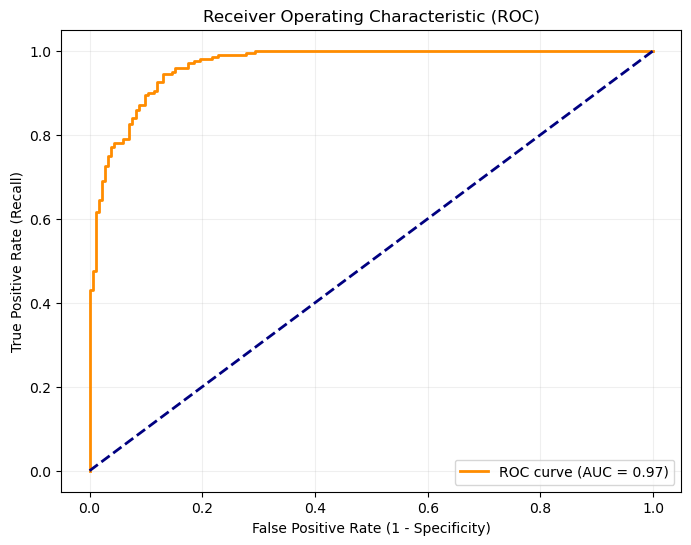

In [2]:
# Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1) 
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.2)
plt.savefig('roc_curve.png', dpi=300)
plt.show()

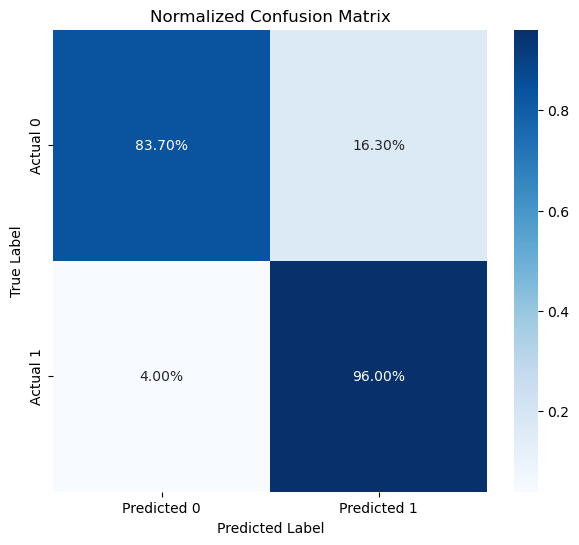

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
# This is crucial for imbalanced datasets or interpreting recall easily
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
plt.figure(figsize=(7, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the figure
plt.savefig('confusion_matrix_normalized.png', dpi=300)
plt.show()

To achieve 95.0% Recall (catching 95% of metastasis),
we should set the threshold to: 0.5148


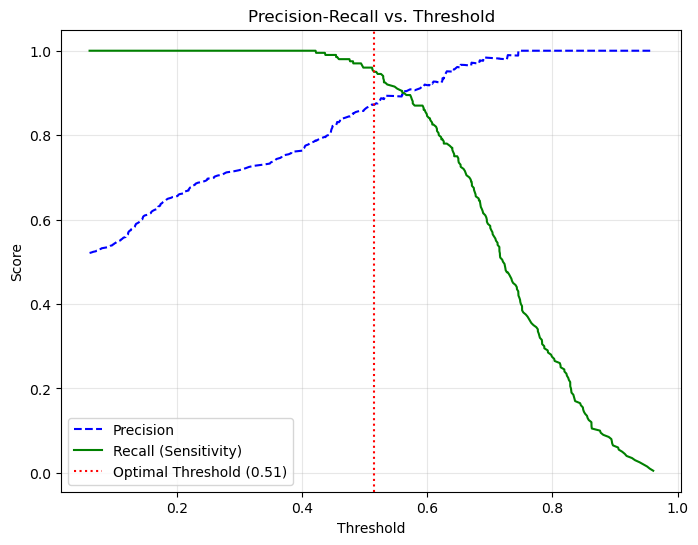

In [4]:
# Analyze how changing the decision threshold affects Recall (Sensitivity)
# We want high Recall for Metastasis to catch all cancer cases

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds_pr, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g-', label='Recall (Sensitivity)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Find the threshold where Recall is roughly 95% (High sensitivity)
# This is "simulating" a clinical screening setting
target_recall = 0.95
optimal_idx = np.argmin(np.abs(recall - target_recall))
optimal_threshold = thresholds_pr[optimal_idx]

print(f"To achieve {target_recall*100}% Recall (catching 95% of metastasis),")
print(f"we should set the threshold to: {optimal_threshold:.4f}")

plt.axvline(x=optimal_threshold, color='r', linestyle=':', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.legend()

plt.savefig('precision_recall_threshold.png', dpi=300)
plt.show()

In [5]:
# Save specific metrics to a text file for documentation
with open("final_model_report.txt", "w") as f:
    f.write("Breast Cancer Metastasis Prediction - Final Report\n")
    f.write("=================================================\n\n")
    f.write(f"ROC-AUC Score: {roc_auc:.4f}\n")
    f.write(f"Optimal Threshold for 95% Recall: {optimal_threshold:.4f}\n")
    f.write("\nConfusion Matrix (Raw):\n")
    f.write(np.array2string(cm))
    f.write("\n\nTop Predictors (Feature Importance):\n")
    # Using the importances from the previous notebook's model (ensure final_rf is in memory)
    # If final_rf is not defined in this notebook, skip this part or reload model
    try:
        importances = final_rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        for f_idx in range(10):
            f.write(f"{X_train.columns[indices[f_idx]]}: {importances[indices[f_idx]]:.4f}\n")
    except NameError:
        f.write("Model feature importances not available in this session.\n")

print("Report saved to 'final_model_report.txt'")

Report saved to 'final_model_report.txt'
